# CAPSTONE 1 - Exploratory Data Analysis


In [2]:
import pandas as pd
import numpy as np
import glob

# Read multiple files into one dataframe

allfiles = glob.glob('caldata\*.csv')
df = pd.concat((pd.read_csv(f, index_col='FL_DATE', parse_dates=True)) for f in allfiles)

print (df.columns)




C:\Users\airshu23\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  


Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 31'],
      dtype='object')


The dataframe constructed above consists of all domestic flights that depart from or arrive at a Californian airport. The data consists of flights from 2013 through 2017. The fields are listed above.

In [3]:
#filling in 
df['ARR_DEL15'] = df['ARR_DEL15'].fillna(value = 0)

print(df.shape)

(6133343, 31)


In [4]:
#checking for null values

print('Origin Airport NANs:' + str(df['ORIGIN_AIRPORT_ID'].isnull().sum()))
print('Destination AIrport NANs:' + str(df['DEST_AIRPORT_ID'].isnull().sum()))
print('Unique Carrier NANs:' + str(df['OP_UNIQUE_CARRIER'].isnull().sum()))
print('Flights NANs: ' + str(df['FLIGHTS'].isnull().sum()))
print('Distance NANs: ' + str(df['DISTANCE'].isnull().sum()))
print('Scheduled Depart Time NANs: ' + str(df['CRS_ELAPSED_TIME'].isnull().sum()))


Origin Airport NANs:0
Destination AIrport NANs:0
Unique Carrier NANs:0
Flights NANs: 0
Distance NANs: 0
Scheduled Depart Time NANs: 5


In [5]:
#dropping samples with NAN

df.dropna(subset=['CRS_ELAPSED_TIME'], inplace = True)

In [6]:
## formatting scheduled departure time in 4 digit format

df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(str)
df['CRS_DEP_TIME']= df['CRS_DEP_TIME'].apply(lambda x: x.zfill(4)) 

df['CRS_DEP_TIME'] = pd.to_datetime(df['CRS_DEP_TIME'], format='%H%M').dt.time
df.index = df.index + pd.to_timedelta(df['CRS_DEP_TIME'].astype(str))


# Exploring the dataset

In [7]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

monthly = df['ARR_DEL15'].resample('M').mean()

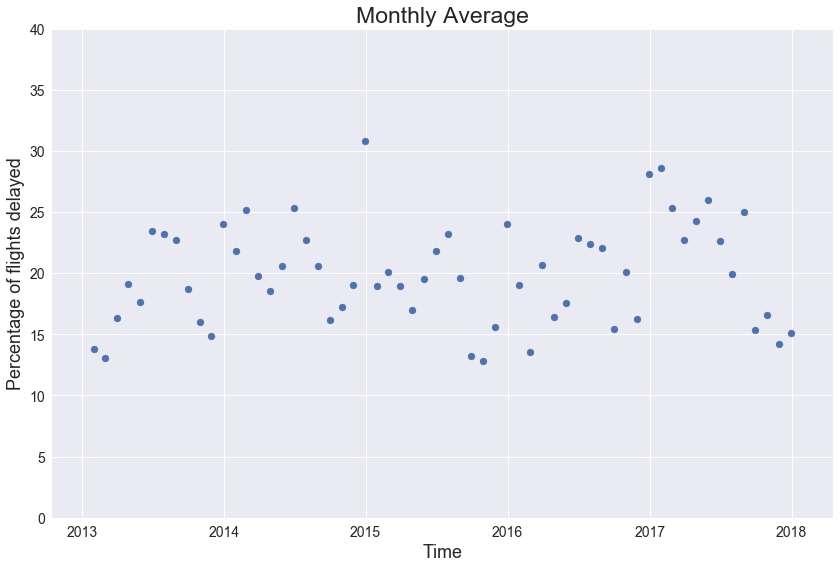

In [8]:
plt.figure(figsize=(14,9))
plt.scatter(monthly.index, monthly.values*100)
plt.title('Monthly Average', fontsize = 23)
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Percentage of flights delayed', fontsize = 18)
plt.xticks(fontsize= 14 )
plt.yticks(fontsize= 14 )
plt.ylim(0, 40)
plt.show()

Based on the graph above, it appears that the proportions of flights that are delayed appears to be roughly cyclical. Delay Rates seem to spike in the middle and at the end of the year. 2018 seems to have been a bit of an anomaly because there was no sharp increase in delays at the end of the year. The range for the percentage of flights delayed go from around 12 to just above 30.

### Traffic patterns over time

In [9]:
# getting count of flights per day

d_traffic = df['FLIGHTS'].resample('D').count()


In [11]:
# averaging daily flight counts over the month

monthly_avg_traffic = d_traffic.resample('M').mean()


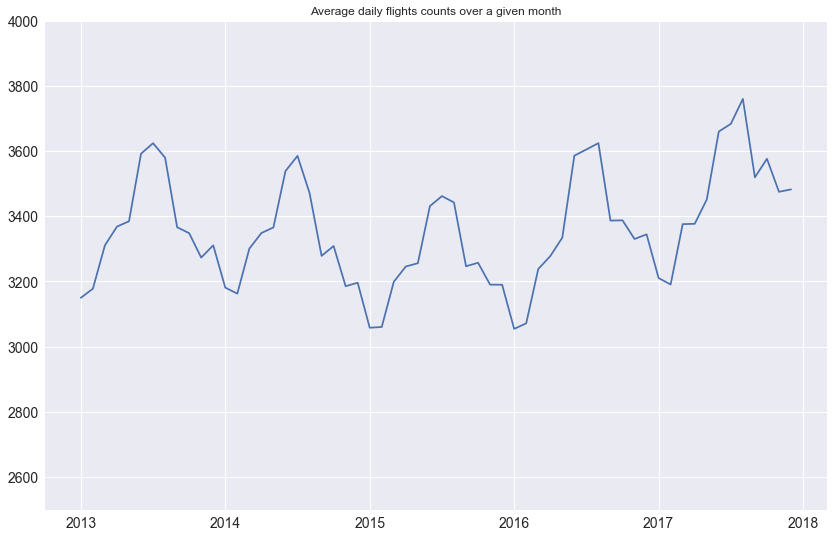

In [12]:
monthly_avg_traffic.plot(figsize=(14,9), ylim= (2500 ,4000), title = 'Average daily flights counts over a given month',
                        fontsize = 14)

There is a clear cyclical pattern in the monthly average of daily number of flights. The traffic is at its peak in the middle of the year. Look at the inferential statistics section for a closer look into the correlation between number of flights and arrival delay rates.

## Distance

### 1) Does composition of flights change, in terms of distance, from quarter to quarter?

In [13]:
# getting mean and std dev of flight distance for a given quarter

mileage_quarterly = df['DISTANCE'].resample('Q').agg([np.mean, np.std])

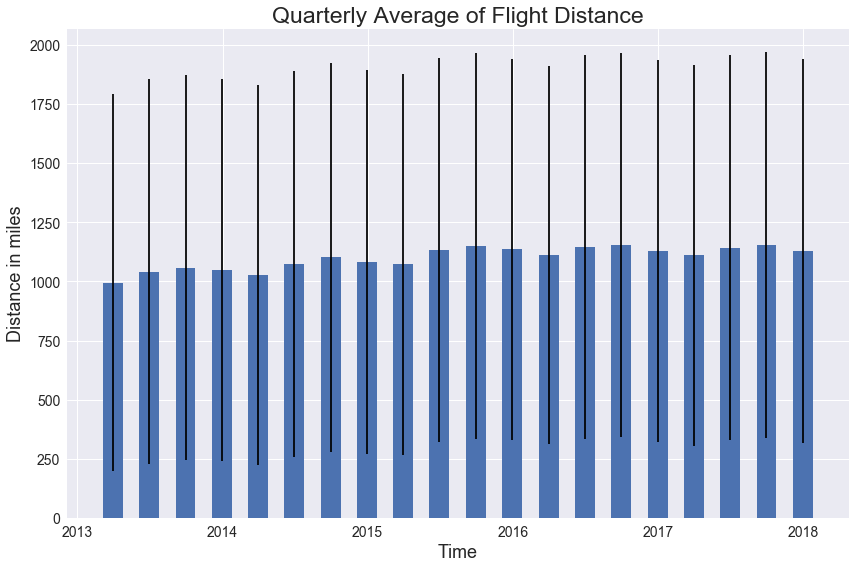

In [14]:
plt.figure(figsize=(14,9))
plt.bar(mileage_quarterly.index, mileage_quarterly['mean'].values, yerr = mileage_quarterly['std'].values,
       ecolor='black', width = 50)

plt.title('Quarterly Average of Flight Distance', fontsize = 23)
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Distance in miles', fontsize = 18)
plt.xticks(fontsize= 14 )
plt.yticks(fontsize= 14 )
plt.show()

Composition of flights, from the standpoint of distance travelled, does not vary much from quarter to quarter within a given year. There does not appear to be a trend from year to year either. (Blue bar denotes average distance. Black line is standard deviation around the mean).

### 2) Is there a relationship between distance and proportion of flights delayed at arrival?

In [15]:
# grouping flights by distance and getting proportion delayed 

mileage_delay = df.groupby('DISTANCE').agg({'ARR_DEL15':'mean'})
mileage_delay.columns = ['Proportion_delayed']

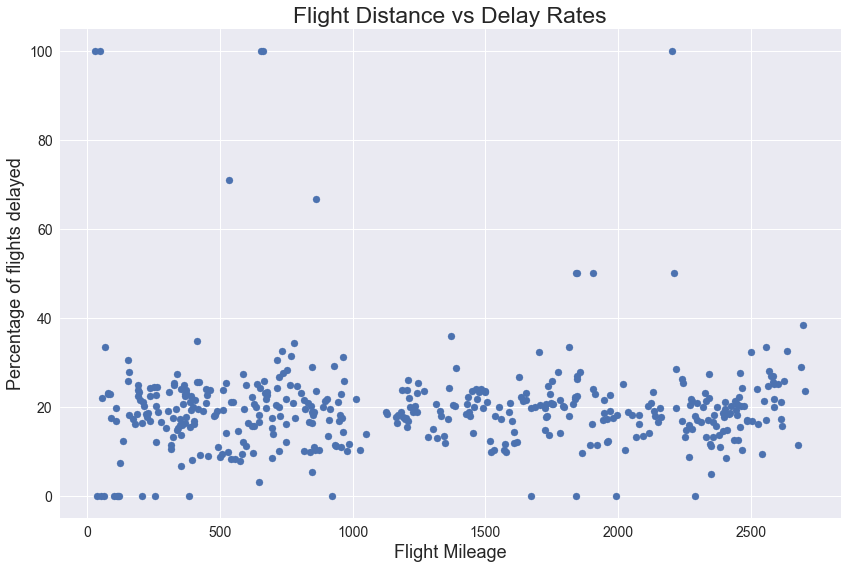

In [16]:
plt.figure(figsize=(14,9))
plt.scatter(mileage_delay.index, mileage_delay.Proportion_delayed.values*100)
plt.xlabel('Flight Mileage', fontsize = 18)
plt.ylabel('Percentage of flights delayed', fontsize = 18)
plt.title('Flight Distance vs Delay Rates', fontsize = 23)
plt.xticks(fontsize= 14 )
plt.yticks(fontsize= 14 )
plt.show()

There is no clear relationship between flight mileage and delay rates. Most data points fall between zero and forty perentage points.  The variance in delay rates seems remarkably steady across the full range. It would appear that distance should not be considered in any regression to predict delay rates.

## Time of Scheduled Departure

### How do delay rates vary with scheduled departure time??

In [17]:
# group by scheduled departure time, aggregate on arrival delay rates.

hour_delay = df.groupby('CRS_DEP_TIME').agg({'ARR_DEL15':['mean', 'count']}) 
hour_delay.columns = ["_".join(x) for x in hour_delay.columns.ravel()]

In [18]:
#removing entries with less than 100 departures for a given departure time

hour_delay = hour_delay.loc[hour_delay['ARR_DEL15_count'] > 100]

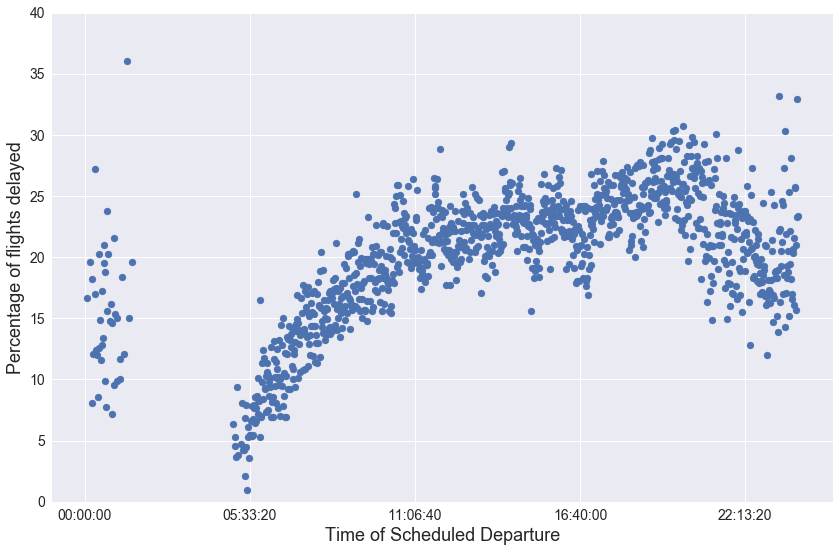

In [19]:
plt.figure(figsize=(14,9))
plt.scatter(hour_delay.index, hour_delay['ARR_DEL15_mean'].values*100)
plt.xlabel('Time of Scheduled Departure', fontsize = 18)
plt.ylabel('Percentage of flights delayed', fontsize = 18)
plt.xticks(fontsize= 14 )
plt.yticks(fontsize= 14 )
plt.ylim(0,40)
plt.show()

Delays are lowest for flights that start around 5 in the morning. Delays steadily climb until around 11 am after which they seem to plateau. There is a slight dip in delays after around 8 pm.

## Breakdown by airlines

### How much does delay rates vary by airline ??

In [20]:
# getting average delay rate for a given airline over each month and year in the dataset

airlines_delay = df.groupby([pd.Grouper(freq='M'), 'OP_UNIQUE_CARRIER']).agg({'ARR_DEL15': ['mean', 'count']})
                             

In [21]:
# renaming columns
airlines_delay.columns = ['proportion_delayed', 'count']

# creating new df by removing low counts from df above
aircarrier_delay = airlines_delay.loc[airlines_delay['count'] > 10 , ['proportion_delayed']].reset_index()
aircarrier_delay.columns = ['date', 'carrier', 'proportion_delayed' ]

In [22]:
print(aircarrier_delay.head(5))

        date carrier  proportion_delayed
0 2013-01-31      AA            0.156841
1 2013-01-31      AS            0.096943
2 2013-01-31      B6            0.150670
3 2013-01-31      DL            0.108824
4 2013-01-31      F9            0.284378


In [23]:
## pivot table: create a column for each airline whose values are proportion of flights delayed

carrier_pivot = aircarrier_delay.pivot_table(index = 'date', columns = 'carrier', values = 'proportion_delayed')

In [24]:
# mean and standard deviation for each airline

means = carrier_pivot.mean(axis = 0)
errors = carrier_pivot.std(axis = 0)

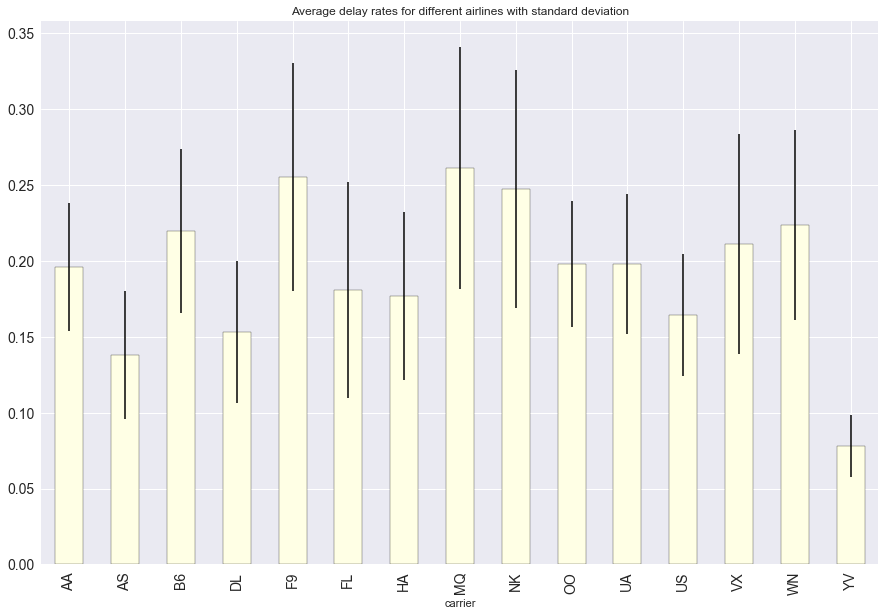

In [25]:
means.plot(kind='bar',yerr=errors,colormap='YlGn',edgecolor='black', figsize=(15,10),
           error_kw=dict(ecolor='black',elinewidth=1.5), fontsize = 14, title =
           "Average delay rates for different airlines with standard deviation")

## Glance at the top 5 busiest airports in California

In [26]:
# airport ID's of the five busiest airports in CA

SFO = 14771
LAX = 12892
SAN = 14679
OAK = 13796
SJC = 14831

five = [SFO, LAX, SAN, OAK, SJC]

#dictionary for later mapping of airport code 

equiv = {SFO : 'SFO', LAX: 'LAX', SAN: 'SAN', OAK: 'OAK', SJC: 'SJC'}

In [27]:
#creating new dataframe where either the destination or origin airport is one of the top 5

top_five = df.loc[(df['ORIGIN_AIRPORT_ID'].isin(five)) | (df['DEST_AIRPORT_ID'].isin(five))]

### 1) Delay rates for flights originating from the top 5 Californian airports

In [28]:
# flights originating from one of the top 5 airports, grouped by year/month and aggregated by mean delay rates

origin = top_five.loc[top_five['ORIGIN_AIRPORT_ID'].isin(five)]
origins = origin.groupby([pd.Grouper(freq='M'), 'ORIGIN_AIRPORT_ID']).agg({'ARR_DEL15': 'mean'}).reset_index()


In [29]:
origins['airport'] = origins['ORIGIN_AIRPORT_ID'].map(equiv)

In [30]:
print(origins.head())

     level_0  ORIGIN_AIRPORT_ID  ARR_DEL15 airport
0 2013-01-31              12892   0.138188     LAX
1 2013-01-31              13796   0.120719     OAK
2 2013-01-31              14679   0.112363     SAN
3 2013-01-31              14771   0.139734     SFO
4 2013-01-31              14831   0.103929     SJC


In [31]:
origin_pivot = origins.pivot_table(index = 'level_0', columns = 'airport', values = 'ARR_DEL15')
origin_pivot.index.names = ['date']

In [32]:
print(origin_pivot.head())

airport          LAX       OAK       SAN       SFO       SJC
date                                                        
2013-01-31  0.138188  0.120719  0.112363  0.139734  0.103929
2013-02-28  0.121237  0.087304  0.113389  0.144603  0.091901
2013-03-31  0.170891  0.128129  0.150269  0.181818  0.135362
2013-04-30  0.184169  0.156199  0.175219  0.220171  0.144737
2013-05-31  0.201994  0.156703  0.171429  0.229302  0.133831


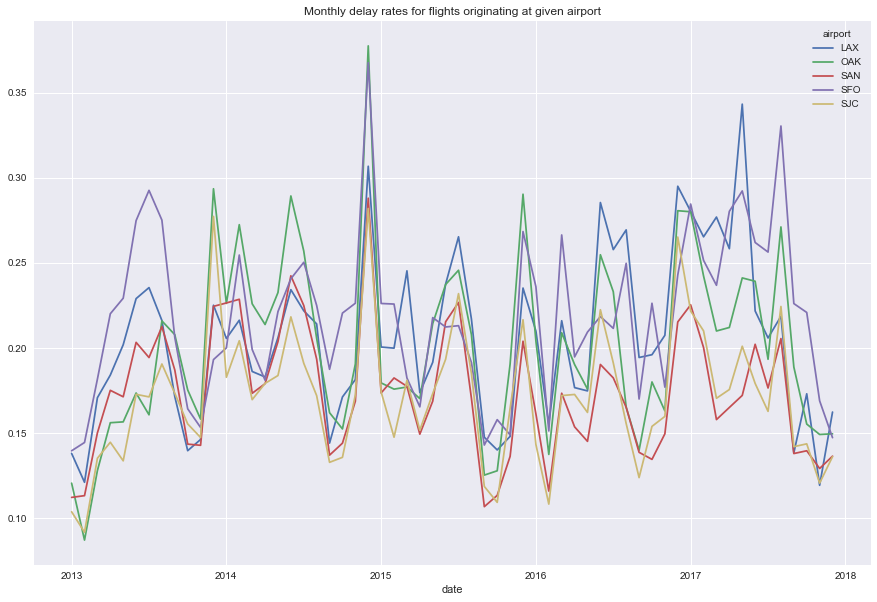

In [33]:
origin_pivot.plot.line(figsize = (15,10), title = 'Monthly delay rates for flights originating at given airport')

The pattern of peak and valleys are fairly similar for all five airports. The relative performance between the airports keeps shuffling from year to year, but San Diego International Airport seems to consistently have the lowest delay rates among these airports.

# Statistical Inference


In [34]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency, pointbiserialr, pearsonr

In [35]:
#TESTING ASSOCIATION BETWEEN AIRLINES AND ARRIVAL DELAY

carrier_delay = df.groupby(df.OP_UNIQUE_CARRIER).agg({'ARR_DEL15': ['sum', 'count']})
carrier_delay.columns = ["_".join(x) for x in carrier_delay.columns.ravel()]

In [36]:
print(carrier_delay)

                   ARR_DEL15_sum  ARR_DEL15_count
OP_UNIQUE_CARRIER                                
9E                           2.0                4
AA                      137403.0           700736
AS                       47663.0           342619
B6                       47091.0           211352
DL                       80626.0           518969
EV                           0.0                1
F9                       15162.0            59367
FL                        1122.0             5914
HA                        7703.0            43469
MQ                        5538.0            21445
NK                       16418.0            67933
OO                      225624.0          1138097
UA                      187054.0           941645
US                       19459.0           118018
VX                       63276.0           294476
WN                      371030.0          1656656
YV                         978.0            12637


## Association between carriers, grouped by flight volume, and flight delay

In [37]:
# get number of non-delayed flights

carrier_delay['no_delay'] = carrier_delay['ARR_DEL15_count'] - carrier_delay['ARR_DEL15_sum']

# create new column that categorizes high and low volume airline carriers
carrier_delay['500k'] = np.where(carrier_delay['ARR_DEL15_count']>= 500000, 'over', 'under')

# grouping carrier_delay by carrier flight count, cutoff = 500k

carrier_delay_group = carrier_delay.groupby('500k').agg({'ARR_DEL15_sum' : 'sum', 'no_delay' : 'sum'})


In [38]:
print(carrier_delay_group)

       ARR_DEL15_sum   no_delay
500k                           
over       1001737.0  3954366.0
under       224412.0   952823.0


In [39]:
obs = np.array([carrier_delay_group['ARR_DEL15_sum'].values,
               carrier_delay_group['no_delay'].values])

print(obs.shape)

(2, 2)


In [40]:
chi2, p, dof, expected = chi2_contingency(obs, correction=False)

print("P-value is " +str(p))
print("Chis statistic: " +str(chi2))

P-value is 6.174698393078882e-173
Chis statistic: 785.9325317398221


Chi-squared test indicates association due to the number of observations. But the practical significance of the difference in delay rates between high and low volume airlines is minimal. In this dataset, high volume airlines are delayed around 20.5%. While low volume carriers are delayed 19.2%.

### Testing association between time of scheduled departure and arrival delay. 24 hour day is broken into 3 hour intervals .

In [41]:
hourly_delay = df.groupby(df.index.hour).agg({'ARR_DEL15': ['sum', 'count']})
hourly_delay.columns = ["_".join(x) for x in hourly_delay.columns.ravel()]

hourly_delay['no_delay'] = hourly_delay['ARR_DEL15_count'] - hourly_delay['ARR_DEL15_sum']


In [42]:
hourly_delay['hour'] = hourly_delay.index

In [43]:
## define 3 hour intervals... starting at 5 am

def intervals(col):
    if col >= 5 and col < 8 :
        return 1
    elif col >= 8 and col < 11:
        return 2
    elif col >= 11 and col < 14:
        return 3
    elif col >= 14 and col < 17:
        return 4
    elif col >= 17 and col < 20:
        return 5
    elif col >= 20 and col < 23:
        return 6
    elif col >= 23 or col < 2:
        return 7
    else:
        return 0

In [44]:
hourly_delay['period'] = hourly_delay['hour'].apply(intervals)

In [45]:
print (hourly_delay)

    ARR_DEL15_sum  ARR_DEL15_count  no_delay  hour  period
0          3757.0            23863   20106.0     0       7
1           605.0             4265    3660.0     1       7
2             0.0                9       9.0     2       0
3             1.0                1       0.0     3       0
4             0.0                1       1.0     4       0
5          4460.0            71061   66601.0     5       1
6         35373.0           433403  398030.0     6       1
7         47608.0           418860  371252.0     7       1
8         67246.0           461611  394365.0     8       2
9         63774.0           383478  319704.0     9       2
10        74355.0           389389  315034.0    10       2
11        77303.0           380134  302831.0    11       3
12        76139.0           369339  293200.0    12       3
13        82755.0           372618  289863.0    13       3
14        76258.0           324818  248560.0    14       4
15        76427.0           328222  251795.0    15      

In [46]:
# Grouping hourly figures into 3 hr intervals and aggregating number of delayed and non-delayed flights 

interval_group = hourly_delay.groupby('period').agg({'ARR_DEL15_sum' : 'sum', 'no_delay': 'sum'})

In [47]:
observation = np.array([interval_group['ARR_DEL15_sum'].values,
               interval_group['no_delay'].values])

chi2_hour, p_hour, dof_hour, expected_hour = chi2_contingency(observation, correction=False)

print("P-value is " +str(p_hour))
print("Chi-2 statistic: " +str(chi2_hour))

P-value is 0.0
Chi-2 statistic: 113491.27312596324


Strong evidence for association between scheduled departure time and arrival delay. This is the strongest association between delay rates and any secondary variable.  This only confirms what was observed graphically in a previous section.

### Relationship between month of flight (grouped by quarters) and delay

In [48]:
quarterly_delay = df.groupby(df.index.quarter).agg({'ARR_DEL15': ['sum', 'count']})
quarterly_delay.columns = ["_".join(x) for x in quarterly_delay.columns.ravel()]

In [49]:
quarterly_delay['no_delay'] = quarterly_delay['ARR_DEL15_count'] - quarterly_delay['ARR_DEL15_sum']

In [50]:
obs_qrt = np.array([quarterly_delay['ARR_DEL15_count'].values,
               quarterly_delay['no_delay'].values])

chi2_qrt, p_qrt, dof_qrt, expected_qrt = chi2_contingency(obs_qrt, correction=False)

print("P-value is " +str(p_qrt))
print("Chis statistic: " +str(chi2_qrt))

P-value is 3.835664835706181e-45
Chis statistic: 209.44633919483346


Not surprisingly, we have evidence of association between quarter of year and delay rates. Consistent with a couple of graphs above, delays consistently spike in the middle and near the end of the calendar year. 

### Correlation between distance and arrival delay

In [51]:
# correlation
r, p_val = pointbiserialr(df.ARR_DEL15.values, df.DISTANCE.values)

print("Correlation is " +str(r))
print("P-stat: " +str(p_val))

Correlation is -0.005253898426838173
P-stat: 1.0502199146886528e-38


There appears to be no correlation between distance and arrival delay. This is a bit counterintuitive because one might have thought that greater distances would allow the aircraft to make up time for any delays leaving origin airport.

### Correlation between traffic and delay

In [52]:
# Correlation between average daily flight traffic over a given month and monthly arrival delay rates.

corr_monthly, p_monthly = pearsonr(monthly_avg_traffic, monthly.values)

print("Correlation between monthly traffic and delay rates: " +str(corr_monthly))
print("P-value: " +str(p_monthly))

Correlation between monthly traffic and delay rates: 0.23168323220797124
P-value: 0.07488289712843425


There is a slight positive correlation when aggregating at the monthly level, as shown above. Below we investigate how this correlation changes when aggregating at the daily level.

In [53]:
#aggregating flight count and average delay rates by date

traffic_day = df.groupby([df.index.date]).agg({'FLIGHTS': 'count', 'ARR_DEL15': 'mean'})
traffic_day.columns = ['flight_count', 'percentage_delay']

corr_traffic_day, p_val_traffic_day = pearsonr(traffic_day.flight_count.values, traffic_day.percentage_delay.values)

print("Correlation between daily traffic and delay rates: " +str(corr_traffic_day))
print("P-val: " +str(p_val_traffic_day))

Correlation between daily traffic and delay rates: 0.3449818006588371
P-val: 3.5015736138070426e-52


The correlation is slightly stronger when aggregated at the daily level. Note that our picture of traffic is skewed because we are counting all flights that involve a Californian airport and none of the flights that do not involve any Californian airport. I suspect the true correlation maybe higher.

# Model Building

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from scipy.stats import randint

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [55]:
#selecting the variables of interest

df2 = df.loc[: , ['YEAR', 'MONTH', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME', 'ARR_DEL15' ]].copy()

In [56]:
#sort flights by date and scheduled departure time
df2.sort_index(inplace=True)

#add hour of day to dataframe , values 1-24
df2['HOUR'] = df2.index.hour

In [57]:
# Group hour of departure into 3 hour segments

df2['PERIOD'] = df2['HOUR'].apply(intervals)

In [58]:
print(df2['PERIOD'].unique())

[7 1 2 3 4 5 6 0]


In [59]:
# dropping HOUR from dataframe
df2 = df2.drop(['HOUR'], axis=1)


In [60]:
# creating categorical variables so python can create dummy variables

df2['ORIGIN_AIRPORT_ID'] = df2['ORIGIN_AIRPORT_ID'].astype('category')
df2['DEST_AIRPORT_ID'] = df2['DEST_AIRPORT_ID'].astype('category')
df2['OP_UNIQUE_CARRIER'] = df2['OP_UNIQUE_CARRIER'].astype('category')
df2['PERIOD'] = df2['PERIOD'].astype('category')
df2['YEAR'] = df2['YEAR'].astype('category')
df2['MONTH'] = df2['MONTH'].astype('category')

In [61]:
# train - holdout split

train = df2.loc['2013-01-01': '2016-12-31']
holdout = df2.loc['2017-01-01': ]

In [65]:
#aggregating arrival delay rates

training = train.groupby(['YEAR', 'MONTH', 'PERIOD', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_UNIQUE_CARRIER']).agg({'ARR_DEL15': 'mean'}).reset_index()

holdouts = holdout.groupby(['YEAR', 'MONTH', 'PERIOD', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OP_UNIQUE_CARRIER']).agg({'ARR_DEL15': 'mean'}).reset_index()

In [67]:
# add column indicating when delay rate for a given entry is over 20%

training['OVER20'] = training['ARR_DEL15'].apply(lambda x: 1 if x >= 0.2 else 0)

holdouts['OVER20'] = holdouts['ARR_DEL15'].apply(lambda x: 1 if x >= 0.2 else 0)


In [68]:
print (training.columns)

Index(['YEAR', 'MONTH', 'PERIOD', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
       'OP_UNIQUE_CARRIER', 'ARR_DEL15', 'OVER20'],
      dtype='object')


In [70]:
# One-hot encode the data using pandas get_dummies

training = pd.get_dummies(training, drop_first = True)
holdouts = pd.get_dummies(holdouts, drop_first = True)

In [71]:
## used to see which of the airlines was encoded

print (training.columns[-20:])

Index(['DEST_AIRPORT_ID_15370', 'DEST_AIRPORT_ID_15376',
       'DEST_AIRPORT_ID_15919', 'DEST_AIRPORT_ID_16218',
       'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
       'OP_UNIQUE_CARRIER_FL', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ',
       'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA',
       'OP_UNIQUE_CARRIER_US', 'OP_UNIQUE_CARRIER_VX', 'OP_UNIQUE_CARRIER_WN',
       'OP_UNIQUE_CARRIER_YV'],
      dtype='object')


In [73]:
# remove dependent variables
X_train = training.drop(['ARR_DEL15', 'OVER20'], axis=1)

# keep only flight departure period (3-hr intervals)
X_train_1 = X_train[['PERIOD_1', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5', 'PERIOD_6', 'PERIOD_7']].values

# same as above with unique carrier added
X_train_2 = X_train[['PERIOD_1', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5', 'PERIOD_6', 'PERIOD_7',
                      'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6',
                      'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
                      'OP_UNIQUE_CARRIER_FL', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ',
                      'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA',
                      'OP_UNIQUE_CARRIER_US', 'OP_UNIQUE_CARRIER_VX', 'OP_UNIQUE_CARRIER_WN',
                      'OP_UNIQUE_CARRIER_YV']].values

X_train_3 = X_train[['PERIOD_1', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5', 'PERIOD_6', 'PERIOD_7',
                      'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6',
                      'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
                      'OP_UNIQUE_CARRIER_FL', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ',
                      'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA',
                      'OP_UNIQUE_CARRIER_US', 'OP_UNIQUE_CARRIER_VX', 'OP_UNIQUE_CARRIER_WN',
                      'OP_UNIQUE_CARRIER_YV', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
                      'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12' ]].values

In [74]:
#continuous dependent variable
y_train = training['ARR_DEL15'].values.reshape(-1,1)

#binary dependent variable

y_binary_train = training['OVER20'].values.reshape(-1,1)

In [76]:
print(type(X_train_1))
print(X_train_1.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
(167435, 7)
(167435, 1)


In [77]:
# remove dependent variables
X_test = holdouts.drop(['ARR_DEL15', 'OVER20'], axis=1)

# keep only flight departure period (3-hr intervals)
X_test_1 = X_test[['PERIOD_1', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5', 'PERIOD_6', 'PERIOD_7']].values


# same as above with unique carrier added
X_test_2 = X_test[['PERIOD_1', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5', 'PERIOD_6', 'PERIOD_7',
                      'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6',
                      'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
                      'OP_UNIQUE_CARRIER_FL', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ',
                      'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA',
                      'OP_UNIQUE_CARRIER_US', 'OP_UNIQUE_CARRIER_VX', 'OP_UNIQUE_CARRIER_WN',
                      'OP_UNIQUE_CARRIER_YV']].values

X_test_3 = X_test[['PERIOD_1', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5', 'PERIOD_6', 'PERIOD_7',
                      'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6',
                      'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
                      'OP_UNIQUE_CARRIER_FL', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ',
                      'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA',
                      'OP_UNIQUE_CARRIER_US', 'OP_UNIQUE_CARRIER_VX', 'OP_UNIQUE_CARRIER_WN',
                      'OP_UNIQUE_CARRIER_YV', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
                      'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12' ]].values

In [78]:
#continuous dependent variable
y_test = holdouts['ARR_DEL15'].values.reshape(-1,1)

#binary dependent variable

y_binary_test = holdouts['OVER20'].values.reshape(-1,1)

### OLS model with only departure time

In [79]:
#Standard OLS
model = LinearRegression()

# Fit the regressor to the training data
model.fit(X_train_1, y_train)
print("Train R^2: {}".format(model.score(X_train_1, y_train)))

# Compute and print R^2 
print("Hold R^2: {}".format(model.score(X_test_1, y_test)))

Train R^2: 0.09588712213865358
Hold R^2: 0.06146631720049577


### OLS model with departure time and unique carrier

In [80]:
#Standard OLS
model2 = LinearRegression()

# Fit the regressor to the training data
model2.fit(X_train_2, y_train)
print("Train R^2: {}".format(model2.score(X_train_2, y_train)))

# Compute and print R^2 
print("Hold out R^2: {}".format(model2.score(X_test_2, y_test)))

Train R^2: 0.1213767275024269
Hold out R^2: 0.06370098599872231


### OLS model with departure time, carrier, month

In [81]:
#Standard OLS
model3 = LinearRegression()

# Fit the regressor to the training data
model3.fit(X_train_3, y_train)
print("Train R^2: {}".format(model3.score(X_train_3, y_train)))

# Compute and print R^2 
print("Hold out R^2: {}".format(model3.score(X_test_3, y_test)))

Train R^2: 0.15507773700464267
Hold out R^2: 0.04062768969185249


###  OLS model with departure time, carrier, year, month, origin/destination airports

In [88]:
#Standard OLS
model4 = LinearRegression()

# Fit the regressor to the training data
model4.fit(X_train, y_train)
print("Train R^2: {}".format(model4.score(X_train, y_train)))

# Compute and print R^2 
print("Hold out R^2: {}".format(model4.score(X_test, y_test)))

Train R^2: 0.21783572303692222
Hold out R^2: -3.191764450401306e+22


### Ridge regression model

In [84]:
#Time series split 
tss = TimeSeriesSplit(n_splits=4)

# Create the hyperparameter grid
param_grid = {'alpha': np.logspace(-3, 3, 13)}

# Instantiate the ridge regressor
ridge = Ridge()

# Setup the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(ridge, param_grid, cv=tss, scoring='r2')

In [85]:
# Fit it to the training data
gs_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 3.16228e-03, 1.00000e-02, 3.16228e-02, 1.00000e-01,
       3.16228e-01, 1.00000e+00, 3.16228e+00, 1.00000e+01, 3.16228e+01,
       1.00000e+02, 3.16228e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [86]:
# Predict on the test set and compute metrics

r2 = gs_cv.score(X_test, y_test)

print(r2)

0.097951291182092


### Checking to see if logistic regression will work

In [91]:
#logistic model with departure times only

clf = LogisticRegression()

# Fit the model on the trainng data
clf.fit(X_train_1, y_binary_train)

# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_test_1), y_binary_test))

C:\Users\airshu23\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6093160781624957


In [98]:
# GridSearch CV

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

param_grid = {'C': Cs }

logreg = LogisticRegression()

logreg_cv = GridSearchCV(logreg, param_grid, cv=tss)
logreg_cv.fit(X_train, y_binary_train.ravel())

print("Best C value using GridSearch and CV: " +str(logreg_cv.best_params_))


# Print the accuracy from the testing data.
print("accuracy score on test set", str(accuracy_score(logreg_cv.predict(X_test), y_binary_test)))

Best C value using GridSearch and CV: {'C': 10}
accuracy score on test set 0.6507541995200549


In [97]:
print(np.mean(y_binary_test))

0.4054707797055574
